In [1]:
import os
import sys
os.chdir('..')
import tqdm

import numpy as np
import tensorflow as tf
import pandas as pd


# Get rid of the deprecation warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import matplotlib.pyplot as plt
import matplotlib as mpl

from models.models import DeepStatisticalSolver
from matplotlib.animation import FuncAnimation
import matplotlib.ticker as ticker

D:\py\anaconda3\envs\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\py\anaconda3\envs\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\py\anaconda3\envs\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\py\anaconda3\envs\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:519: 

In [2]:
# We need this short method to compute the flows based on the heads
def compute_flows(A, B, H):
    
    A_offset = A \
        + np.shape(B)[1] \
        * np.reshape(np.arange(np.shape(A)[0]), [-1, 1, 1]) \
        * np.array([[[1., 1., 0.]]])

    
    i_from = A_offset[:, :, 0].astype(np.int32)
    i_to = A_offset[:, :, 1].astype(np.int32)
    A_ij = A_offset[:, :, 2].astype(np.float32)
    
    elevation = B[:, :, 3]
    Nd = B[:, :, 0]
    Nh = B[:, :, 2]
    elevation = np.reshape(elevation, -1)
    Nd = np.reshape(Nd, -1)
    Nh = np.reshape(Nh, -1)
    
    H_i = H[i_from]*Nd[i_from] + (1-Nd[i_from]) * elevation[i_from]
    H_j = H[i_to]*Nd[i_to]  + (1-Nd[i_to]) * elevation[i_to]

    
    H_ij = H_i - H_j
    Q_ij = np.sign(H_ij)* (np.maximum(np.abs(H_ij),1e-9)*A_ij)**(1/1.852)

    return Q_ij

In [3]:
def CalculateMetrics(model, A_np, B_np, U_np, sess):
    # For the whole dataset, we will compute both the individual loss of each sample, 
    # and the final predictions
    costs_DSS = None
    costs_NR = None

    Vm_DSSs = None
    Va_DSSs = None
    Vm_NRs = None
    Va_NRs = None

    P_ij_DSSs = None
    Q_ij_DSSs = None
    P_ij_NRs = None
    Q_ij_NRs = None

    # In order to split the dataset, define the size of the batches that will be fed to the model.
    # For very large dataset, it can be useful to have a small value for BATCH_SIZE
    BATCH_SIZE = 100

    # Get total amount of samples and split the dataset
    n_samples_tot = A_np.shape[0]
    n_batches = n_samples_tot // BATCH_SIZE
    batched_indices = np.array_split(np.arange(n_samples_tot), n_batches) 

    # Iterate over the batches
    for indices in tqdm.tqdm(batched_indices):

        U_DSS, cost_DSS = sess.run([model.U_final, model.cost_per_sample[str(model.correction_updates)]], 
                 feed_dict = {model.A:A_np[indices], model.B:B_np[indices]}
                )

        cost_NR = sess.run(model.cost_per_sample[str(model.correction_updates)], 
                 feed_dict = {model.A:A_np[indices], model.B:B_np[indices], model.U_final:U_np[indices]}
                )

        # Getting predicted HEAD
        H_DSS = U_DSS[:, :, 0]
        H_DSS = np.reshape(H_DSS, -1)

        # Getting actual HEAD
        H_NR = U_np[indices, :, 0]
        H_NR = np.reshape(H_NR, -1)
           

        Q_ij_DSS = compute_flows(A_np[indices], 
                                             B_np[indices], 
                                             H_DSS)

        Q_ij_NR = compute_flows(A_np[indices], 
                                         B_np[indices], 
                                         H_NR)

        Q_ij_DSS = np.reshape(Q_ij_DSS, -1)
        Q_ij_NR = np.reshape(Q_ij_NR, -1)


        
        if costs_DSS is None:
            costs_DSS = cost_DSS
            costs_NR = cost_NR
            H_DSSs = H_DSS
            H_NRs = H_NR
            Q_ij_DSSs = Q_ij_DSS
            Q_ij_NRs = Q_ij_NR

        else:
            costs_DSS = np.concatenate([costs_DSS, cost_DSS])
            costs_NR = np.concatenate([costs_NR, cost_NR])
            H_DSSs = np.concatenate([H_DSSs, H_DSS])
            H_NRs = np.concatenate([H_NRs, H_NR])
            Q_ij_DSSs = np.concatenate([Q_ij_DSSs, Q_ij_DSS])
            Q_ij_NRs = np.concatenate([Q_ij_NRs, Q_ij_NR])
            
    print('Loss - GNS')
    print('    10th percentile = {}'.format(np.percentile(costs_DSS, 10)))
    print('    50th percentile = {}'.format(np.percentile(costs_DSS, 50)))
    print('    90th percentile = {}'.format(np.percentile(costs_DSS, 90)))
    print('Loss - NR')
    print('(Keep in mind that the maximum precision achieved by tf.float32 is around 1e-14')
    print('Thus the loss computed by tensorflow is noisy)')
    print('    10th percentile = {}'.format(np.percentile(costs_NR, 10)))
    print('    50th percentile = {}'.format(np.percentile(costs_NR, 50)))
    print('    90th percentile = {}'.format(np.percentile(costs_NR, 90)))
    print('Correlation between methods')
    print('    Correlation H = {}'.format(np.corrcoef(H_DSSs,H_NRs)[1,0]))
    print('    Correlation Qij = {}'.format(np.corrcoef(Q_ij_DSSs,Q_ij_NRs)[1,0]))
    print('RMSE between methods')
    print('    RMSE H = {}'.format(np.sqrt(np.mean((H_DSSs-H_NRs)**2))))
    print('    RMSE Qij = {}'.format(np.sqrt(np.mean((Q_ij_DSSs-Q_ij_NRs)**2))))
    print('normalized RMSE between methods')
    print('    normalized RMSE H = {}'.format(np.sqrt(np.mean((H_DSSs-H_NRs)**2))\
          /(np.max(H_NRs)-np.min(H_NRs))))
    print('    normalized RMSE Qij = {}'.format(np.sqrt(np.mean((Q_ij_DSSs-Q_ij_NRs)**2))\
          /(np.max(Q_ij_NRs)-np.min(Q_ij_NRs))))
    print('MAE between methods')
    print('    MAE H = {}'.format(np.mean(np.abs(H_DSSs-H_NRs))))
    print('    MAE Qij = {}'.format(np.mean(np.abs(Q_ij_DSSs-Q_ij_NRs))))
    print('normalized MAE between methods')
    print('    normalized MAE H = {}'.format(np.mean(np.abs(H_DSSs-H_NRs))\
          /(np.max(H_NRs)-np.min(H_NRs))))
    print('    normalized MAE Qij = {}'.format(np.mean(np.abs(Q_ij_DSSs-Q_ij_NRs))\
          /(np.max(Q_ij_NRs)-np.min(Q_ij_NRs))))
    
    rmse_h_values = np.sqrt(np.mean((H_DSSs - H_NRs) ** 2))
    mean_rmse_h = np.mean(rmse_h_values)
    std_rmse_h = np.std(rmse_h_values)

    print('均值 RMSE H = {}'.format(mean_rmse_h))
    print('标准差 RMSE H = {}'.format(std_rmse_h))

    return H_NRs, H_DSSs, Q_ij_NRs, Q_ij_DSSs

In [4]:
model_path = "results/1716448839" # supervised trained on asnet2_1, k=l=20,no scaling on H loss, initalized at 399
name='supervised'
# Enter path to data to build architecture
data_dir = 'datasets/asnet38'

# Initialize a tensorflow session
sess = tf.Session()
# Build the Deep Statistical Solver
model = DeepStatisticalSolver(sess, 
                          model_to_restore=model_path, 
                          default_data_directory=data_dir)

In [5]:
# Load the test set (change the mode variable if you want val or train)
data_dir = 'datasets/asnet38'
mode = 'test'

# Import numpy data
A_np = np.load(os.path.join(data_dir, 'A_'+mode+'.npy'))
B_np = np.load(os.path.join(data_dir, 'B_'+mode+'.npy'))
U_np = np.load(os.path.join(data_dir, 'U_'+mode+'.npy'))
# coord_np = np.load(os.path.join(data_dir, 'coord_'+mode+'.npy'))
H_NRs, H_DSSs, Q_ij_NRs, Q_ij_DSSs = CalculateMetrics(model, A_np, B_np, U_np, sess)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:28<00:00,  1.65s/it]


Loss - GNS
    10th percentile = 0.6862887263298034
    50th percentile = 0.7157418131828308
    90th percentile = 0.7585343718528748
Loss - NR
(Keep in mind that the maximum precision achieved by tf.float32 is around 1e-14
Thus the loss computed by tensorflow is noisy)
    10th percentile = 0.6828186273574829
    50th percentile = 0.7155049443244934
    90th percentile = 0.7616797566413879
Correlation between methods
    Correlation H = 0.8676016935111489
    Correlation Qij = 0.5116147637405656
RMSE between methods
    RMSE H = 0.03936161350207932
    RMSE Qij = 0.01441740568992107
normalized RMSE between methods
    normalized RMSE H = 0.042522876915757284
    normalized RMSE Qij = 0.020523537517514116
MAE between methods
    MAE H = 0.015862600314885757
    MAE Qij = 0.008142130340766222
normalized MAE between methods
    normalized MAE H = 0.01713657903576812
    normalized MAE Qij = 0.011590526140082585
均值 RMSE H = 0.03936161350207932
标准差 RMSE H = 0.0


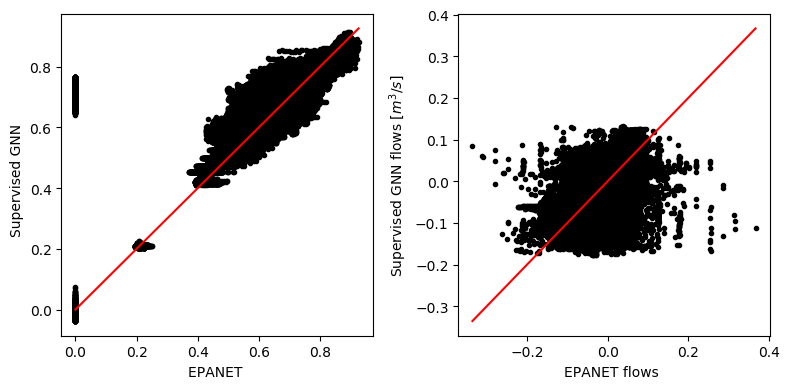

In [6]:
H_min_max = [np.min(H_NRs), np.max(H_NRs)]
Q_min_max = [np.min(Q_ij_NRs), np.max(Q_ij_NRs)]
fig,axs = plt.subplots(1,2, figsize = (8,4))
axs[0].plot(H_NRs, H_DSSs,'k.')
axs[0].plot(H_min_max,H_min_max, 'r-')
axs[0].set_xlabel('EPANET ')
axs[0].set_ylabel('Supervised GNN  ');
axs[1].plot(Q_ij_NRs, Q_ij_DSSs,'k.')
axs[1].plot(Q_min_max,Q_min_max, 'r-')
axs[1].set_xlabel('EPANET flows ')
axs[1].set_ylabel('Supervised GNN flows [$m^3/s$]')
plt.tight_layout()
fig.savefig('correlation_'+name+'.png', dpi=500)

(1652924,)


D:\py\anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  
D:\py\anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide


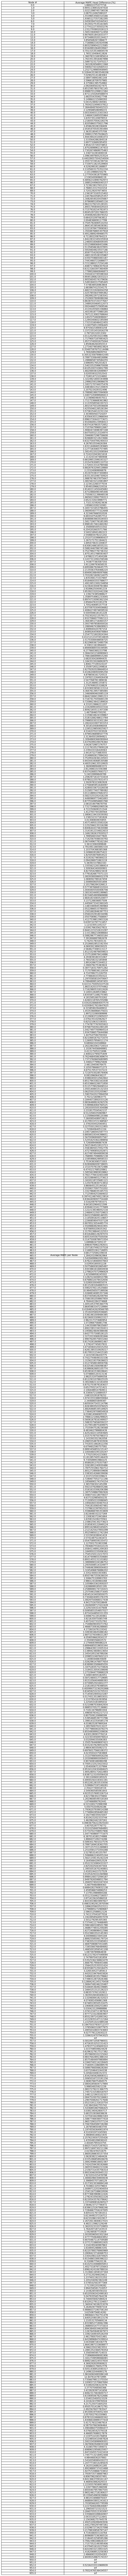

In [7]:
# Plot error bar on nodes
n_node = np.shape(B_np[0])[0]
n_edge = np.shape(A_np[0])[0]

# Reshape the arrays
H_NR_node = H_NRs.reshape((-1, n_node))
H_DSS_node = H_DSSs.reshape((-1, n_node))
print(H_NRs.shape)
H_NRs = H_NRs.reshape((-1, n_node))
H_DSSs = H_DSSs.reshape((-1, n_node))

# 计算绝对差异
H_diff = np.abs(H_NR_node - H_DSS_node)

# 计算每个节点在每个样本上的MAPE
H_MAPE_per_sample = np.abs(H_diff / H_NRs) * 100

# 计算每个节点的平均MAPE
H_MAPE_per_node = np.mean(H_MAPE_per_sample, axis=0)


# Compute the absolute difference
H_diff = np.abs(H_NR_node - H_DSS_node)

# 计算每个节点在每个样本上的MAPE
H_MAPE_per_sample = np.abs(H_diff / H_NRs) * 100

# 计算每个节点的平均MAPE
H_MAPE_per_node = np.mean(H_MAPE_per_sample, axis=0)

# 创建一个包含节点的平均MAPE的DataFrame
data_mape = {
    'Node #': np.arange(n_node),
    'Average MAPE Head Difference [%]': H_MAPE_per_node
}

df_mape = pd.DataFrame(data_mape)

# 显示MAPE表格
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')
table_mape = ax.table(cellText=df_mape.values, colLabels=df_mape.columns, cellLoc='center', loc='center')
table_mape.auto_set_font_size(False)
table_mape.set_fontsize(12)
table_mape.scale(1.2, 1.2)

plt.title('Average MAPE per Node')
plt.show()
# 保存MAPE表格为CSV文件
df_mape.to_csv('average_mape_per_node38（正确方法3）.csv', index=False)




